In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import eig
from sklearn.preprocessing import Imputer
from future_encoders import OrdinalEncoder,OneHotEncoder
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [12]:
print("Welcome to Dashboard")
print("")
url = input("Enter the url for the data (CSV Format): ")
op_count = 0
flag = 0
ans = 0
cat_flag=0
num_flag=0
ch = 0
ch_num = 0
missing = []
mis_flag = 0
strat_ch = 0

Welcome to Dashboard

Enter the url for the data (CSV Format): housing.csv


In [13]:
data = pd.read_csv(url)
print('Data Type Summary: ')
print("")
print(data.info())
print('-------------------------------------------------------------------------------------')
print('An Introduction to the data')
print("")
print(data.head())
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
num_df = data[num_cols]
cat_df = data[cat_cols]
print('-------------------------------------------------------------------------------------')
print('Identified numerical valued features: ')
for i in range(num_df.shape[1]):
    print(num_df.columns[i])
    num_flag = 1
print('-------------------------------------------------------------------------------------')
print('Identified categorical valued features')
for i in range(cat_df.shape[1]):
    print(cat_df.columns[i])
    cat_flag = 1
print('-------------------------------------------------------------------------------------')
    
data_frame = data
unique = data_frame[data_frame.columns[data_frame.shape[1]-1]].unique().tolist()
print(unique)

Data Type Summary: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
-------------------------------------------------------------------------------------
An Introduction to the data

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85  

1: Label Encoding
2: One-hot Encoding
Enter the operation you wish to perform on the categorical features: 2
-------------------------------------------------------------------------------------
The data has been one-hot encoded
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------

Performing missing value detection and handling on the numerical features: 
The data contains missing values which should be handled

The features with missing values: 
total_bedrooms
-------------------------------------------------------------------------------------

1: Mean
2: Median
3: Most Frequent
Enter the strategy to be applied for handling the missing values in the detected features: 2

The missing values have been detected and handled
-------------------------------------------------------------------------------------

Scaling the numerical data: 

1: Z-Score standardization
2: 

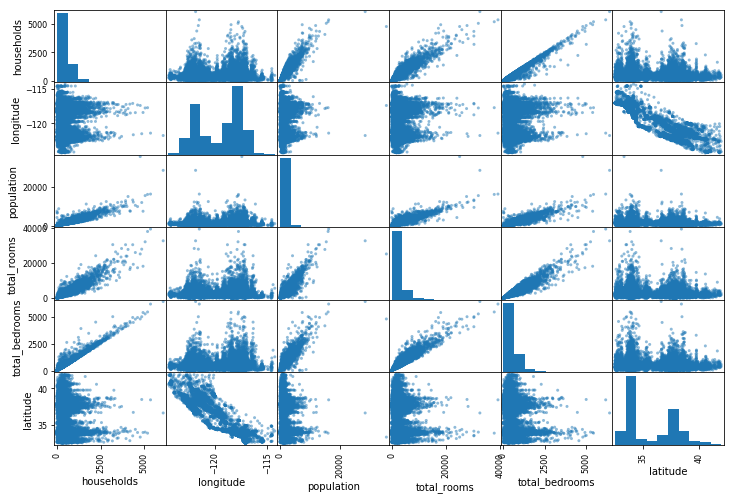

Multicollinearity exists in the data (eigen system analysis)
Result Post Eigen System Analysis:
Number of near linear dependencies in the data: 1
VIF Values:
8.703623263308453
8.826607057876732
1.2590642255246862
12.126381925963162
26.88208451658468
6.261679929388118
28.284141128756033
1.688920032272462

Result Post VIF Analysis: 
Number of regressors exhibiting near linear dependence: 3


In [14]:
def z_score_standardization(data):
    for i in range(data.shape[1]):
            x = data[:,i]
            x_mean = np.mean(x)
            x_stdev = np.sqrt(np.mean(np.square(x)) - np.square(x_mean))
            z = (x - x_mean)/x_stdev
            data[:,i] = z
    return data

def max_min_normalization(data):
    for j in range(data.shape[1]):
            x = data[:,j]
            x_min = min(x)
            x_max = max(x)
            x_maxmin = (x - x_min)/(x_max - x_min)
            data[:,j] = x_maxmin
    return data

def Multicollinearity_Analysis(data):
    X = data[:,0:(data.shape[1]-1)]
    Y = data[:,(data.shape[1]-1)]
    graph_set = set([])
    corr_matrix = np.dot(X.T,X)/data.shape[0]
    print('Correlation Matrix Analysis:')
    print("")
    print(corr_matrix)
    print("")
    print('Correlation Analysis between Pair Wise Regressors: ')
    reg_count = 0
    print("")
    for i in range((corr_matrix.shape[0])):
        for j in range(i+1,corr_matrix.shape[1]):
            if(abs(corr_matrix[i][j])>0.9 and corr_matrix[i][j]<0.99):
                print('Regressors: '+data_frame.columns[i]+' '+data_frame.columns[j])
                graph_set.add(data_frame.columns[i])
                graph_set.add(data_frame.columns[j])
                reg_count+=1
    print("")
    print('-------------------------------------------------------------------------------------')
    print('Correlation Graphical Analysis: ')
    print("")
    graph_final = list(graph_set)
    if(reg_count>0):
        scatter_matrix(data_frame[graph_final],figsize=(12,8))
        plt.show()
    elif(reg_count==0):
        print('No multicollinearity detected between pair wise regressors')
        print("")
            
    e1,e2 = eig(corr_matrix)
    e1 = abs(e1)
    index = np.argsort(e1)[::-1]
    e2 = e2[:,index]
    condition_number = e1[0]/e1[(corr_matrix.shape[0]-1)]
    multicol=0
    if(condition_number>100):
        multicol=1
    else:
        multicol=0
    if(multicol==1):
        print('Multicollinearity exists in the data (eigen system analysis)')
    else:
        print('The data is free from any multicollinearity issue (eigen system analysis)')
    count=0
    if(multicol==1):
        for i in range(len(e1)):
            if(e1[0]/e1[i]>=100):
                count+=1
        print('Result Post Eigen System Analysis:')
        print('Number of near linear dependencies in the data: '+str(count))
        corr_matrix_inv = np.linalg.inv(corr_matrix)
        vif_count=0
        print('VIF Values:')
        for i in range(len(corr_matrix_inv)):
            print(corr_matrix_inv[i][i])
            if(corr_matrix_inv[i][i]>=10):
                vif_count+=1  
        print("")
        print('Result Post VIF Analysis: ')
        print('Number of regressors exhibiting near linear dependence: '+str(vif_count))
    
        
def cat_to_num(df,ch):
    if ch==1:                                                                    
        ordinal_encoder = OrdinalEncoder()
        df_encoded = ordinal_encoder.fit_transform(df)
        return df_encoded
    elif ch==2:
        onehot_encoder = OneHotEncoder(sparse=False)
        df_1hot = onehot_encoder.fit_transform(df)
        return df_1hot

def MVD(data_frame):
    missing = data_frame.columns[data_frame.isna().any()].tolist()
    data_matrix = data_frame.values
    if(len(missing)==0):
        print('The data does not contain any missing values')
        mis_flag = 0
    else:
        print('The data contains missing values which should be handled')
        mis_flag = 1
        print("")
        print('The features with missing values: ')
        for i in range(len(missing)):
            print(missing[i])
        print('-------------------------------------------------------------------------------------')
        print("")
    if(mis_flag==1):
        print('1: Mean')
        print('2: Median')
        print('3: Most Frequent')
        strat_ch = int(input('Enter the strategy to be applied for handling the missing values in the detected features: '))
        if(strat_ch==1):
            imputer = Imputer(strategy = "mean")
        elif(strat_ch==2):
            imputer = Imputer(strategy = "median")
        elif(strat_ch==3):
            imputer = Imputer(strategy = "most_frequent")
        imputer.fit(data_matrix)
        data_matrix = imputer.transform(data_matrix)
        print("")
        print('The missing values have been detected and handled')
    print('-------------------------------------------------------------------------------------')
    print("")
    return data_matrix

if(cat_flag==1):
    print('1: Label Encoding')
    print('2: One-hot Encoding')
    ch = int(input('Enter the operation you wish to perform on the categorical features: '))
    print('-------------------------------------------------------------------------------------')
    data_cat = cat_to_num(cat_df,ch)
    if(ch==1):
        print('The data has been ordinal/label encoded')
        print('-------------------------------------------------------------------------------------')
        print("")
    elif(ch==2):
        print('The data has been one-hot encoded')
        print('-------------------------------------------------------------------------------------')
        print("")
        
elif(cat_flag==0):
    print('The data is devoid of any categorical features.')   
print('-------------------------------------------------------------------------------------')
print("")

print('Performing missing value detection and handling on the numerical features: ')
data_matrix = MVD(num_df)
print('Scaling the numerical data: ')
print("")
print('1: Z-Score standardization')
print('2: Max-min normalization')
ch_num = int(input('Choose the required scaling technique: '))
if(ch_num==1):
    data_matrix = z_score_standardization(data_matrix)
    print('The data has been z-score standardized')
    print('-------------------------------------------------------------------------------------')
if(ch_num==2):
    data_matrix = max_min_normalization(data_matrix)
    print('The data has been max-min normalized')
    print('-------------------------------------------------------------------------------------')
print("")
print('Performing Multicollinearity Analysis:')
Multicollinearity_Analysis(data_matrix)
    